# Text Classification

supervised learning paper

# 1)- Importing key Modules

In [1]:
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import string 
import requests
import pickle
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# for text analysis and model
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\69785hsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [4]:
# For ML algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

# 2)- Loading dataset

In [5]:
df = pd.read_csv('hassan_paper2.csv')
df.head()

,appln,appln_id,family_id,direct,granted,num_keywds,num_emergent,label,keywds,earliest_appln,...,citing_publn_date,citing_publn,citing_appln,citing_appln_id,citing_family_id,num_citing_family,earliest_applt,current_applt,appln_title,appln_abstr
0,AP9000171A,468568,3460643,1,1,1,1,ET,Augmented Reality,AP9000171A,...,NaN,NaN,NaN,NaN,NaN,0,WILLMET INC.,WILLMET INC.,Method and apparatus for flame spraying refrac...,A method and apparatus for flame spraying refa...
1,FR9502814A,20497049,3478912,1,0,1,1,ET,Virtual Assistants,AR32920294A,...,1998-06-16\n2005-07-01\n2007-10-11\n2013-02-08...,ES2115541A1\nFR2864473A1\nDE102006013700B3\nES...,ES9601564A\nFR0315329A\nDE102006013700A\nES201...,17616260\n19068617\n15027713\n380582103\n38105...,8295481\n34639568\n38513697\n47566167\n4756616...,6,MAIZTEGUI GUILLERMO MARTIN,MAIZTEGUI GUILLERMO MARTIN,Anti-dazzle system for automobile headlights,"On the source vehicle (Ve), polarising screens..."
2,EP93101056A,16978302,3483979,1,0,1,1,ET,Augmented Reality,AT19492A,...,1994-05-18,EP0597301A1,EP93117135A,16992465,3530063,1,Chemie Linz Gesellschaft m.b.H.,Chemie Linz Gesellschaft m.b.H.,"Amidoimidobisphenoles, their preparation and t...",Amidoimidobisphenols of the formula <IMAGE> in...
3,WO9701165W,15681989,3490916,1,0,1,1,ET,Augmented Reality,AT44996A,...,NaN,NaN,NaN,NaN,NaN,0,DSM Chemie Linz GmbH,DSM Chemie Linz GmbH,BISMALEIMIDE RESINS CONTAINING LESS THAN 0.1 W...,The invention concerns bismaleimide resins bas...
4,EP06025028A,16301300,3497932,1,0,1,1,ET,Augmented Reality,AT71696A,...,NaN,NaN,NaN,NaN,NaN,53,Sanochemia Pharmazeutika Aktiengesellschaft,Sanochemia Pharmazeutika Aktiengesellschaft,"New benzazepine derivatives, medicaments conta...","Benzofuro[3a,3,2,ef][2]benzazepines (I), their..."


In [6]:
df.shape

(283212, 37)

In [7]:
len(df.keywds.value_counts())

406

In [8]:
df.num_emergent.value_counts()

1    176367
0    105032
2      1798
3        15
Name: num_emergent, dtype: int64

In [9]:
df.label.value_counts()

ET     176367
NET    105032
CET      1813
Name: label, dtype: int64

In [10]:
df.label.unique()

array(['ET', 'NET', 'CET'], dtype=object)

In [11]:
#df[df['label']=="ET"]

# 3)- Data Exploring

### a) Selecting most relevant features for initial pre-processing and data creation

In [12]:
data=df[['keywds','num_keywds','label','appln_title','appln_abstr']]

In [13]:
data.head()

,keywds,num_keywds,label,appln_title,appln_abstr
0,Augmented Reality,1,ET,Method and apparatus for flame spraying refrac...,A method and apparatus for flame spraying refa...
1,Virtual Assistants,1,ET,Anti-dazzle system for automobile headlights,"On the source vehicle (Ve), polarising screens..."
2,Augmented Reality,1,ET,"Amidoimidobisphenoles, their preparation and t...",Amidoimidobisphenols of the formula <IMAGE> in...
3,Augmented Reality,1,ET,BISMALEIMIDE RESINS CONTAINING LESS THAN 0.1 W...,The invention concerns bismaleimide resins bas...
4,Augmented Reality,1,ET,"New benzazepine derivatives, medicaments conta...","Benzofuro[3a,3,2,ef][2]benzazepines (I), their..."


In [14]:
data.num_keywds.nunique()

6

In [15]:
data.num_keywds.unique()

array([1, 2, 3, 4, 6, 5], dtype=int64)

In [16]:
data.keywds.unique()

array(['Augmented Reality', 'Virtual Assistants', '5G',
       'Hybrid Cloud Computing', 'Social TV',
       'Volumetric/Holographic Displays', 'ASICs',
       'Augmented Reality\nBYOD', 'BYOD', 'Deep Reinforcement Learning',
       'Virtual Reality', 'In Memory Analytics', 'Quantum Computing',
       'Internet TV', 'Private Cloud Computing',
       'Autonomous Mobile Robots',
       'Tangible/Conversational User Interfaces', 'Big Data',
       'NFC (Payments)', 'Interactive TV', 'Electrovibration',
       'Autonomous Vehicles', 'Cryptocurrencies', 'Digital Twin',
       '5G\nAugmented Reality',
       'Hybrid Cloud Computing\nQuantum Computing', '3D Scanners',
       'Knowledge Graphs', 'Edge Computing',
       'Virtual Assistants\nVirtual Reality',
       'Augmented Reality\nVirtual Assistants', 'Application Stores',
       'Gamification', 'Video Search', 'Solid State Drives',
       'Electrovibration\nVirtual Assistants',
       'In Memory Analytics\nInteractive TV', 'QR/Color Code'

### b)- Mapping df into three labelled classes

- ET......emerging technology ===> Refers to all technologies in Gartner Hype Cycle
- CET.....Convergent ET ===> Those technologies that are combination two or more technologies e.g IOT, 5G,machine learning is combination of 3.
- NET: Non- emerging tech ====> All those that are not in ET & CET

In [17]:
data['label'].value_counts()

ET     176367
NET    105032
CET      1813
Name: label, dtype: int64

### c)-Label the categorical values

In [18]:
data['num_label'] = data.label.map({'NET':0, 'CET':1, 'ET':2})

In [19]:
data.head()

,keywds,num_keywds,label,appln_title,appln_abstr,num_label
0,Augmented Reality,1,ET,Method and apparatus for flame spraying refrac...,A method and apparatus for flame spraying refa...,2
1,Virtual Assistants,1,ET,Anti-dazzle system for automobile headlights,"On the source vehicle (Ve), polarising screens...",2
2,Augmented Reality,1,ET,"Amidoimidobisphenoles, their preparation and t...",Amidoimidobisphenols of the formula <IMAGE> in...,2
3,Augmented Reality,1,ET,BISMALEIMIDE RESINS CONTAINING LESS THAN 0.1 W...,The invention concerns bismaleimide resins bas...,2
4,Augmented Reality,1,ET,"New benzazepine derivatives, medicaments conta...","Benzofuro[3a,3,2,ef][2]benzazepines (I), their...",2


### d)- Checking abstract

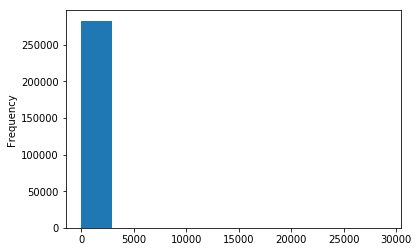

In [21]:
data['appln_abstr'].str.len().plot.hist()

# 4)- Cleaning

In [22]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [23]:
data['cleaned']=[text_prepare(x) for x in data['appln_abstr']]

In [24]:
print(data.appln_abstr[:5])

0    A method and apparatus for flame spraying refa...
1    On the source vehicle (Ve), polarising screens...
2    Amidoimidobisphenols of the formula <IMAGE> in...
3    The invention concerns bismaleimide resins bas...
4    Benzofuro[3a,3,2,ef][2]benzazepines (I), their...
Name: appln_abstr, dtype: object


In [25]:
data.cleaned[:5]

0    method apparatus flame spraying refactory mate...
1    source vehicle polarising screens 1 placed fro...
2    amidoimidobisphenols formula image ar pphenyle...
3    invention concerns bismaleimide resins based a...
4    benzofuro 3a 3 2 ef 2 benzazepines ringopened ...
Name: cleaned, dtype: object

In [26]:
print(len(data.appln_abstr[4]))
print(len(data.cleaned[4]))

3169
2268


In [27]:
data.head()

,keywds,num_keywds,label,appln_title,appln_abstr,num_label,cleaned
0,Augmented Reality,1,ET,Method and apparatus for flame spraying refrac...,A method and apparatus for flame spraying refa...,2,method apparatus flame spraying refactory mate...
1,Virtual Assistants,1,ET,Anti-dazzle system for automobile headlights,"On the source vehicle (Ve), polarising screens...",2,source vehicle polarising screens 1 placed fro...
2,Augmented Reality,1,ET,"Amidoimidobisphenoles, their preparation and t...",Amidoimidobisphenols of the formula <IMAGE> in...,2,amidoimidobisphenols formula image ar pphenyle...
3,Augmented Reality,1,ET,BISMALEIMIDE RESINS CONTAINING LESS THAN 0.1 W...,The invention concerns bismaleimide resins bas...,2,invention concerns bismaleimide resins based a...
4,Augmented Reality,1,ET,"New benzazepine derivatives, medicaments conta...","Benzofuro[3a,3,2,ef][2]benzazepines (I), their...",2,benzofuro 3a 3 2 ef 2 benzazepines ringopened ...


In [28]:
df_clean=data[['keywds','num_keywds','label','num_label','appln_title','cleaned']]

In [29]:
import pickle
df_clean.to_pickle('text_classify_clean.pkl')
df_clean.to_csv('text_classify_clean.csv', index=False)

### 4.2)-most common words

In [30]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in data['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('data', 208437),
 ('method', 200199),
 ('system', 187585),
 ('device', 182212),
 ('invention', 141250),
 ('information', 139659),
 ('image', 131075),
 ('power', 126920),
 ('carbon', 123515),
 ('one', 116804)]

### 4.3)-Splitting data
Split X and y into training and testing sets

In [31]:
X=data['cleaned']
y=data['num_label']

In [32]:
X.head()

0    method apparatus flame spraying refactory mate...
1    source vehicle polarising screens 1 placed fro...
2    amidoimidobisphenols formula image ar pphenyle...
3    invention concerns bismaleimide resins based a...
4    benzofuro 3a 3 2 ef 2 benzazepines ringopened ...
Name: cleaned, dtype: object

In [33]:
y[:5]

0    2
1    2
2    2
3    2
4    2
Name: num_label, dtype: int64

In [34]:
print(X.shape)
print(y.shape)

(283212,)
(283212,)


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(212409,)
(70803,)
(212409,)
(70803,)


### 4.4)- Vectorize

Applying tf-idf

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test - input text       
        return TF-IDF vectorizer for each dataset
    """
    
    # filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the tweets)
    # ngram!!! -->  ngram_range=(1,2)
    tfidf_vectorizer = TfidfVectorizer(max_features=1000,ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
    
    # Fit and transform the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Only Transform the test sets 
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_
    
    
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)

In [37]:
# convert to dense array
X_train_tfidf=X_train_tfidf.toarray()

In [38]:
X_train_tfidf

array([[0.        , 0.05956327, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04591913, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.10345984, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17818871, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [39]:
type(X_train_tfidf)

numpy.ndarray

In [40]:
X_test_tfidf=X_test_tfidf.toarray()

In [41]:
y_train[5:10]

76984     0
186850    0
201257    0
92072     0
176148    0
Name: num_label, dtype: int64

# 5)-Naive Bayes Model

In [42]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tfidf,y_train)
predmnb = mnb.predict(X_test_tfidf)

In [43]:
predmnb

array([2, 2, 2, ..., 2, 0, 0], dtype=int64)

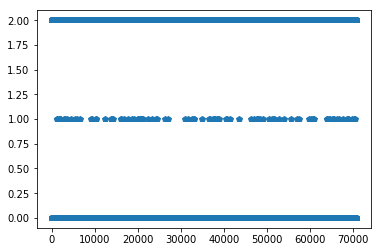

In [44]:
import matplotlib.pyplot as plt
plt.plot(predmnb, "p")

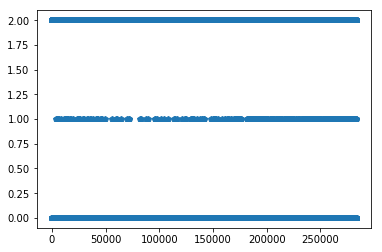

In [45]:
plt.plot(y_test, "p")

### 5.1)-Making the confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predmnb)
cm

array([[22941,     0,  3250],
       [   21,    56,   364],
       [ 3603,    42, 40526]], dtype=int64)

### 5.2)-Checking accuracy score

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predmnb)

0.8971794980438682

In [48]:
from sklearn.metrics import classification_report
print (classification_report(y_test, predmnb))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     26191
           1       0.57      0.13      0.21       441
           2       0.92      0.92      0.92     44171

   micro avg       0.90      0.90      0.90     70803
   macro avg       0.78      0.64      0.67     70803
weighted avg       0.90      0.90      0.90     70803

